# Deep Learning Programming Ex 02: Multi-Class SVM

In this exercise you will:

- Build the general architecture of a multi-class SVM, including:
    - Calculating the cost function and its gradient
    - Find the optimal hyperparameters by cross validation

Instruction:

- Run each cell and read the comments carefully (in the right order)
- Implement the missing codes that are required

# Load Required Libraries [0pt]

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time

## CIFAR-10 load data [0pt]

Run the next cell to define a data helper function that does some basic preprocessing.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../../data/cifar/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Task 1: Multi-Class SVM - Loss Function and Gradients [5pt]

Complete the implementation of svm_loss_naive by implementing a naive analytical gradient descent that uses nested loops.

In [7]:
def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero
    num_classes = W.shape[1]
    num_samples = X.shape[0]

    #############################################################################
    # TODO: Compute the multi-class svm loss and its gradient using explicit    #
    # loops. Store the loss in loss and the gradient in dW. Don't forget the    #
    # regularization!                                                           #
    #############################################################################

    loss = 0.0
    for i in range(num_samples):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
                
            margin = scores[j] - correct_class_score + 1 # Delta = 1
            
            if margin > 0:
                loss += margin
                dW[:,j] += X[i]
                dW[:,y[i]] -= X[i]
  
 
    loss /= num_samples
    loss += reg * np.sum(W[:W.shape[0]-1,:] * W[:W.shape[0]-1,:])
  
    dW /= num_samples
    dW[:W.shape[0]-1,:] += reg * 2 * W[:W.shape[0]-1,:]
    
    #############################################################################
    #                         END OF YOUR CODE                                  #
    #############################################################################
    return loss, dW

# Check: Gradients [0pt] 

The next cell is a self-check for you to make sure your SVM implementation works!
It compares your analytical gradients to numerically calculated gradients.
The numerical and analytical values should be the same up to printing accurracy,
relative error should be smaller than $10^{-7}$.

In [8]:
# Compute the loss and its gradient at W.
W = np.random.randn(3073, 10) * 0.0001 
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from utils.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -7.669782,	analytic: -7.669782,	relative error: 7.748795e-12
numerical: 23.902312,	analytic: 23.902312,	relative error: 1.314050e-11
numerical: -19.185722,	analytic: -19.185722,	relative error: 2.650223e-12
numerical: -2.780978,	analytic: -2.780978,	relative error: 1.218197e-11
numerical: -3.188550,	analytic: -3.188550,	relative error: 3.100811e-11
numerical: -13.679014,	analytic: -13.679014,	relative error: 5.798379e-12
numerical: 7.098582,	analytic: 7.098582,	relative error: 4.823015e-11
numerical: -53.292125,	analytic: -53.292125,	relative error: 3.346044e-12
numerical: 20.772704,	analytic: 20.772704,	relative error: 2.831548e-11
numerical: 0.436102,	analytic: 0.436102,	relative error: 1.990901e-10
numerical: 8.933169,	analytic: 8.933169,	relative error: 1.466953e-11
numerical: 9.874929,	analytic: 9.874929,	relative error: 1.521589e-11
numerical: -3.973107,	analytic: -3.973107,	relative error: 2.929451e-11
numerical: -3.014324,	analytic: -3.014324,	relative error: 4.98871

# Task 2: Multi-Class SVM [5pt]

Implement a vectorized version of the SVM loss function.

In [9]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    num_classes = W.shape[1]
    num_train = X.shape[0]
    
    scores = np.dot(X,W)
    
    correct_class_scores = scores[range(num_train),y]
    
    margins = scores - correct_class_scores[:, None] + 1
    margins[range(num_train),y] = 0
    loss = np.sum(np.maximum(0,margins))/num_train
    loss += reg * np.sum(W[:W.shape[0]-1,:] * W[:W.shape[0]-1,:]) 
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################


    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    
    # partial gradients for each training example:
    slopes = np.zeros((margins.shape)) # default case for correct classifications
    slopes[margins > 0] = 1            # where j = k
    slopes[range(num_train),y] -= np.sum(slopes, axis = 1) # sum over classes
    
    dW = np.dot(X.T,slopes)
    dW /= num_train
    
    # -1 indexing to exclude bias in normalization
    dW[:W.shape[0]-1,:] += reg * 2 * W[:W.shape[0]-1,:]
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return loss, dW

# Check: Performance Comparison [0pt]

Execute the cell below to run a performance comparison between the naive implementation using loops
and the optimized version using vectorized instructions.
The two versions should compute the same results, but the vectorized version should be much faster.

In [10]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff = tic - toc
print('Naive loss: %e computed in %fs' % (loss_naive, diff))

tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff_vec = tic - toc
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, diff_vec))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)
print('Runtime abs. difference: %f seconds' % (diff_vec - diff))
print('Runtime rel. improvement: %f percent' % (1 - (diff_vec / diff)))

Naive loss: 9.234943e+00 computed in -0.089722s
Vectorized loss: 9.234943e+00 computed in -0.011968s
Loss difference: 0.000000
Gradient difference: 0.000000
Runtime abs. difference: 0.077754 seconds
Runtime rel. improvement: 0.866608 percent


# Stochastic Gradient Descent [0pt]

You already implemented this in the last exercise. Please run the cell below to define this function in the current namespace.

In [13]:
# train multi-class svm by SGD, implemented in last assignment
def train_SGD(X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    W: A numpy array of shape (D, C) containing weights
    loss_history: A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
   
    # Generate a random softmax weight matrix
    W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
        X_batch = None
        y_batch = None
        p = np.random.choice(num_train, batch_size)
        X_batch = X[p,:]
        y_batch = y[p]
  

        # evaluate loss and gradient
        loss, grad = svm_loss_vectorized(W,X_batch, y_batch, reg)
        loss_history.append(loss)
 
        W -= learning_rate*grad

        if verbose and it % 100 == 0:
            print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return W, loss_history

# SVM Training [0pt]

Run the next cell to train a SVM classifier using stochastic gradient descent.

In [14]:
tic = time.time()
W, loss_hist = train_SGD(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('This took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.408175
iteration 100 / 1500: loss 289.407001
iteration 200 / 1500: loss 108.223558
iteration 300 / 1500: loss 42.311947
iteration 400 / 1500: loss 18.879998
iteration 500 / 1500: loss 10.443825
iteration 600 / 1500: loss 7.203802
iteration 700 / 1500: loss 5.845857
iteration 800 / 1500: loss 5.623011
iteration 900 / 1500: loss 4.998946
iteration 1000 / 1500: loss 5.001992
iteration 1100 / 1500: loss 5.318446
iteration 1200 / 1500: loss 4.893186
iteration 1300 / 1500: loss 5.286149
iteration 1400 / 1500: loss 5.128230
This took 3.690551s


# Check: Prediction [0pt]

The next two cells  defines the predict function. 

In [15]:
def predict(W, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    y_pred = np.argmax(np.dot(X,W),axis=1)
    return y_pred

In [16]:
# Write the predict function and evaluate the performance on both the
# training and validation set
y_train_pred = predict(W,X_train)
print('training accuracy: %f' % np.mean(y_train == y_train_pred))
y_val_pred = predict(W,X_val)
print('validation accuracy: %f' % np.mean(y_val == y_val_pred))

training accuracy: 0.372510
validation accuracy: 0.380000


# Task 3: Hyperparameter Tuning [5pt]

Follow the instructions in the comments and run a hyperparameter tuning adapted to a SVM.

In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-8, 1e-8]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_W = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

num_test = X_test.shape[0]
for lr in learning_rates:
    for reg in regularization_strengths:
        W, loss_hist = train_SGD(X_train, y_train, lr, reg, num_iters=1500,verbose=True)
        y_train_pred = predict(W, X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = predict(W, X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = train_acc, val_acc
        if best_val < val_acc:
            best_val = val_acc
            best_W = W
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 794.487550
iteration 100 / 1500: loss 289.409179
iteration 200 / 1500: loss 109.626095
iteration 300 / 1500: loss 43.069856
iteration 400 / 1500: loss 19.130393
iteration 500 / 1500: loss 10.370561
iteration 600 / 1500: loss 7.217847
iteration 700 / 1500: loss 5.888128
iteration 800 / 1500: loss 5.517014
iteration 900 / 1500: loss 5.468424
iteration 1000 / 1500: loss 5.267671
iteration 1100 / 1500: loss 5.414655
iteration 1200 / 1500: loss 5.796165
iteration 1300 / 1500: loss 5.507645
iteration 1400 / 1500: loss 5.455994
iteration 0 / 1500: loss 1547.523745
iteration 100 / 1500: loss 209.142886
iteration 200 / 1500: loss 32.339435
iteration 300 / 1500: loss 9.928616
iteration 400 / 1500: loss 6.100158
iteration 500 / 1500: loss 6.491223
iteration 600 / 1500: loss 5.159212
iteration 700 / 1500: loss 5.841443
iteration 800 / 1500: loss 5.522359
iteration 900 / 1500: loss 5.828422
iteration 1000 / 1500: loss 4.899274
iteration 1100 / 1500: loss 5.618420
iteration 

# Check: Test Accuracy and Weight Visualization [0pt]

Run the next cell to try your SVM implementation on unseen test data. Accuracy should be around 0.35.
The last cell displays the (rescaled) weights your SVM has learned for each class.

In [18]:
# Evaluate the best svm on test set
y_test_pred = predict(best_W,X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.367000


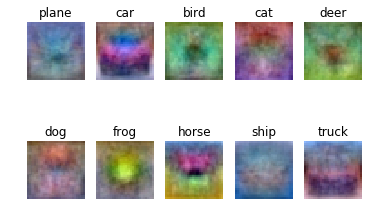

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])